### 1. Importação e Preparo dos Dados

In [19]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, recall_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import memory_profiler


### 2. Carregar e Inspecionar os Dados

In [20]:
# Carregar o dataset pré-processado
data = pd.read_csv('../data/speeddating_preprocessed.csv', sep=';')

# Verificar primeiras linhas
data.head()

# Verificar classes da variável alvo
print(data['match'].value_counts())

match
0    6998
1    1380
Name: count, dtype: int64


### 3. Pré-Processamento dos Dados

In [21]:
# Separar variáveis preditoras e alvo
X = data.drop(columns=['match'])
y = data['match']

In [22]:
# Supondo que X seja um DataFrame do pandas
# Identifique as colunas categóricas
categorical_features = ['age_group']  # substitua 'age_range' pelo nome da coluna real
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

# Crie os transformadores para colunas categóricas e numéricas
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Crie um ColumnTransformer para aplicar as transformações apropriadas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [23]:
# Normalizar os dados
# scaler = StandardScaler()
X_scaled = preprocessor.fit_transform(X)

# Balancear os dados usando SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

# Verificar distribuição após balanceamento
print(y_train.value_counts())
print(y_test.value_counts())


match
1    4899
0    4898
Name: count, dtype: int64
match
0    2100
1    2099
Name: count, dtype: int64


### 4. Definir Função de Treinamento e Avaliação

In [24]:
def train_and_evaluate(model, model_name, X_train, y_train, X_test, y_test):
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')

    start_train = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_train

    start_test = time.time()
    y_pred = model.predict(X_test)
    test_time = time.time() - start_test

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    acsa = balanced_accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    results = {
        "Model": model_name,
        "Accuracy": acc,
        "F1 Score": f1,
        "Recall": recall,
        "ACSA": acsa,
        "Train Time (s)": train_time,
        "Test Time (s)": test_time,
        "Validation Accuracy (CV)": scores.mean(),
        "Confusion Matrix": cm
    }
    return results

### 5. Ajuste fino para SVM e MLP utilizando o optuna

In [25]:
# Ajuste fino usando Optuna para SVM
def svm_objective(trial):
    C = trial.suggest_loguniform('C', 1e-3, 1e2)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    gamma = trial.suggest_loguniform('gamma', 1e-3, 1e1)
    svm = SVC(C=C, kernel=kernel, gamma=gamma, random_state=42)
    scores = cross_val_score(svm, X_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()

svm_study = optuna.create_study(direction='maximize')
svm_study.optimize(svm_objective, n_trials=50)

best_svm_params = svm_study.best_params
print("Melhores parâmetros para SVM:", best_svm_params)

[I 2024-11-24 13:28:08,006] A new study created in memory with name: no-name-13167b5e-958c-4d30-bba8-dc8a2af79875
C:\Users\lucas\AppData\Local\Temp\ipykernel_20852\4078439707.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
C:\Users\lucas\AppData\Local\Temp\ipykernel_20852\4078439707.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-3, 1e1)
[I 2024-11-24 13:28:14,284] Trial 0 finished with value: 0.9942839432863497 and parameters: {'C': 87.8458182483877, 'kernel': 'poly', 'gamma': 0.006443235965860751}. Best is trial 0 with value: 0.9942839432863497.
C:\Users\lucas\AppData\Loc

Melhores parâmetros para SVM: {'C': 0.1883285574479646, 'kernel': 'rbf', 'gamma': 0.005733440545322976}


In [26]:
# Ajuste fino usando Optuna para MLP
def mlp_objective(trial):
    hidden_layer_sizes = trial.suggest_int('hidden_layer_sizes', 10, 200)
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-1)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'adam'])
    mlp = MLPClassifier(hidden_layer_sizes=(hidden_layer_sizes,), alpha=alpha, solver=solver, random_state=42, max_iter=500)
    scores = cross_val_score(mlp, X_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()

mlp_study = optuna.create_study(direction='maximize')
mlp_study.optimize(mlp_objective, n_trials=50)

best_mlp_params = mlp_study.best_params
print("Melhores parâmetros para MLP:", best_mlp_params)

[I 2024-11-24 13:36:17,778] A new study created in memory with name: no-name-12a05d03-9541-4047-890b-c576230a6480
C:\Users\lucas\AppData\Local\Temp\ipykernel_20852\309649670.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-1)
[I 2024-11-24 13:36:33,061] Trial 0 finished with value: 1.0 and parameters: {'hidden_layer_sizes': 185, 'alpha': 0.04632315374895793, 'solver': 'adam'}. Best is trial 0 with value: 1.0.
C:\Users\lucas\AppData\Local\Temp\ipykernel_20852\309649670.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-1)
[I 2024-11-24 13:36:39,601] Trial 1 finished 

Melhores parâmetros para MLP: {'hidden_layer_sizes': 185, 'alpha': 0.04632315374895793, 'solver': 'adam'}


### 6. Treinamento de Modelos

In [27]:
# Lista de modelos
models = [
    (KNeighborsClassifier(), 'K-NN'),
    (DecisionTreeClassifier(random_state=42), 'Decision Tree'),
    (SVC(probability=True, random_state=42), 'SVM'),
    (RandomForestClassifier(random_state=42), 'Random Forest'),
    (MLPClassifier(random_state=42, max_iter=500), 'MLP Neural Network'),
    (XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), 'XGBoost'),
    (LGBMClassifier(random_state=42), 'LightGBM')
]

# Avaliar modelos
all_results = []
for model, name in models:
    results = train_and_evaluate(model, name, X_train, y_train, X_test, y_test)
    all_results.append(results)

# Criar DataFrame com resultados
results_df = pd.DataFrame(all_results)


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:43:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:43:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:43:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:43:26] WAR

[LightGBM] [Info] Number of positive: 4409, number of negative: 4408
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27527
[LightGBM] [Info] Number of data points in the train set: 8817, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500057 -> initscore=0.000227
[LightGBM] [Info] Start training from score 0.000227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

### 7. Visualização dos Resultados
- Grafico boxplot para comparar os modelos com a validação cruzada
- Matriz de confusão para avaliar o modelo com os dados de teste

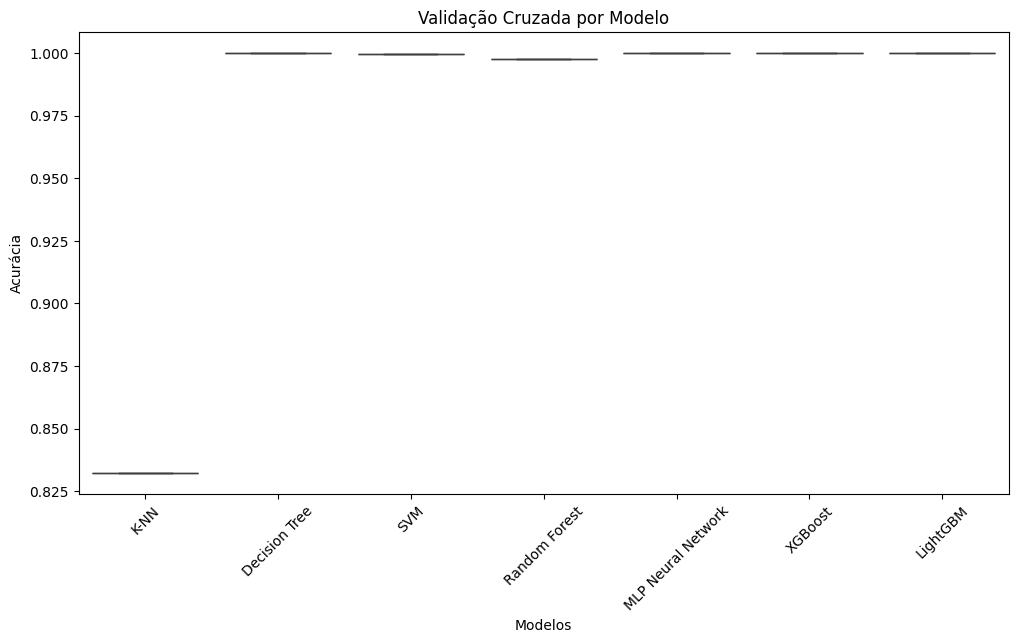

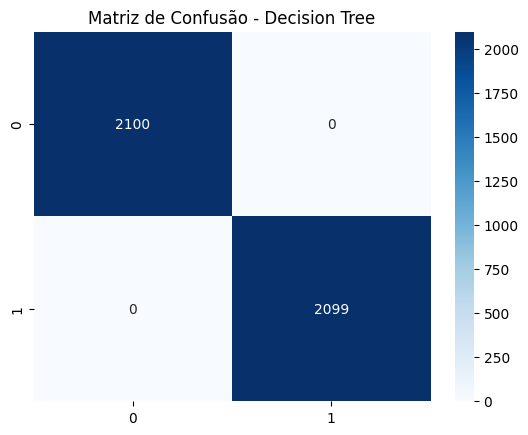

In [28]:
# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='Model', y='Validation Accuracy (CV)')
plt.title('Validação Cruzada por Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Modelos')
plt.xticks(rotation=45)
plt.show()

# Matriz de Confusão para o melhor modelo
best_model_idx = results_df['Accuracy'].idxmax()
cm = results_df.iloc[best_model_idx]['Confusion Matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusão - {results_df.iloc[best_model_idx]["Model"]}')
plt.show()


### 1. Gráfico de Dispersão: Relacionando Tempo e Acurácia
- Este gráfico mostrará o tempo de treinamento e tempo de inferência no eixo X e a acurácia no eixo Y.

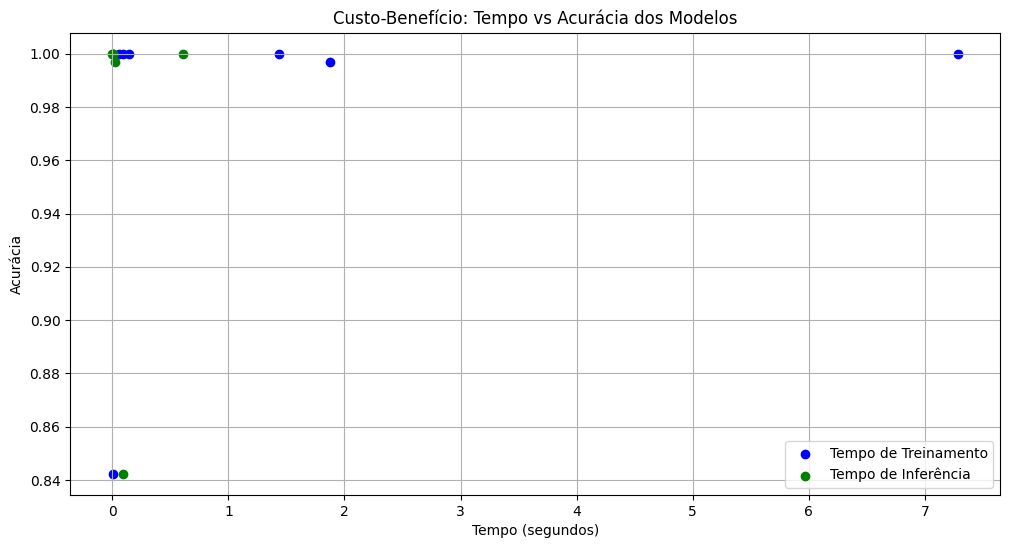

In [32]:
# Gráfico de dispersão: Tempo de Treinamento vs Acurácia
plt.figure(figsize=(12, 6))

# Plotar tempo de treinamento
plt.scatter(results_df['Train Time (s)'], results_df['Accuracy'], color='blue', label='Tempo de Treinamento')

# Plotar tempo de inferência
plt.scatter(results_df['Test Time (s)'], results_df['Accuracy'], color='green', label='Tempo de Inferência')

plt.title('Custo-Benefício: Tempo vs Acurácia dos Modelos')
plt.xlabel('Tempo (segundos)')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()

### 2. Gráfico de Barras Agrupadas: Comparação de Tempo
- Compara o tempo de treinamento, tempo de inferência e acurácia lado a lado para cada modelo.

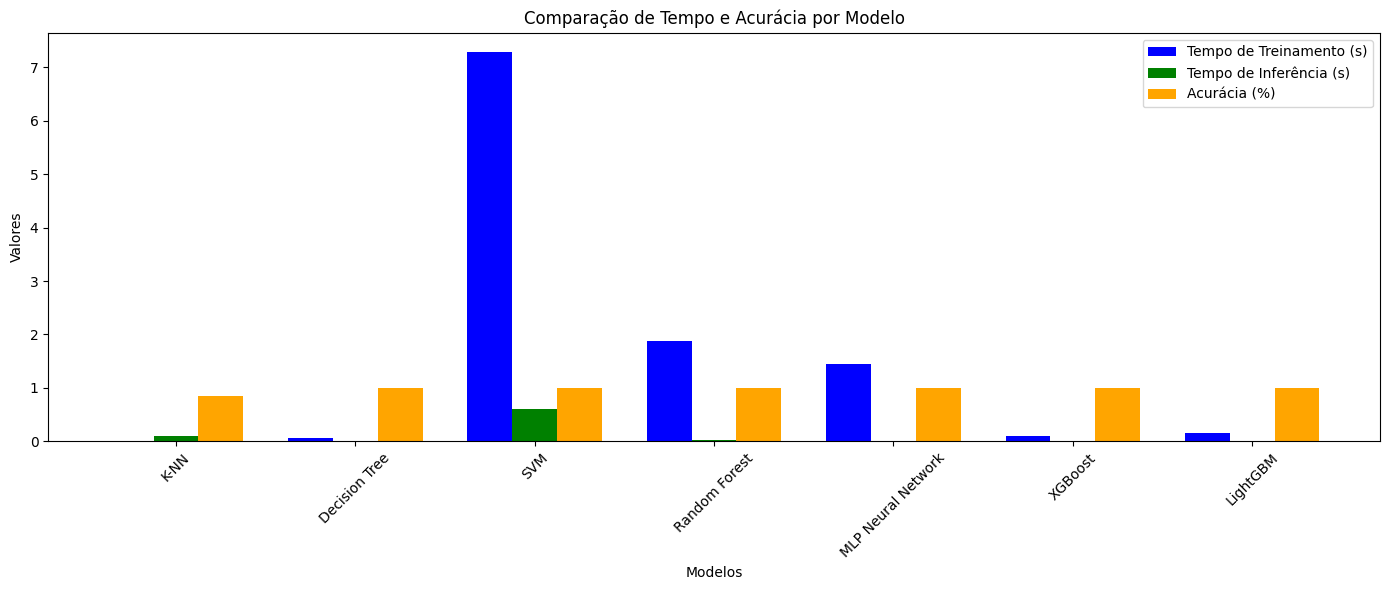

In [33]:
# Gráfico de barras agrupadas: Tempo de Treinamento, Tempo de Inferência e Acurácia
# Dados para o gráfico
model_names = results_df['Model']
train_times = results_df['Train Time (s)']
test_times = results_df['Test Time (s)']
accuracies = results_df['Accuracy']

# Configurar o eixo X
x = np.arange(len(model_names))

# Configurar o gráfico
width = 0.25  # Largura das barras
plt.figure(figsize=(14, 6))

# Barras de tempo de treinamento
plt.bar(x - width, train_times, width, label='Tempo de Treinamento (s)', color='blue')

# Barras de tempo de inferência
plt.bar(x, test_times, width, label='Tempo de Inferência (s)', color='green')

# Barras de acurácia (convertidas para proporção para alinhamento)
plt.bar(x + width, accuracies, width, label='Acurácia (%)', color='orange')

# Personalização
plt.xlabel('Modelos')
plt.ylabel('Valores')
plt.title('Comparação de Tempo e Acurácia por Modelo')
plt.xticks(x, model_names, rotation=45)
plt.legend()
plt.tight_layout()

# Mostrar o gráfico
plt.show()


### 8. Teste de Estresse

In [29]:
# Gerar dados desconhecidos
new_data = np.random.normal(size=(100, X_train.shape[1]))
new_preds = models[0][0].predict(new_data)  # Usando o primeiro modelo como exemplo
print("Previsões com dados novos:", new_preds)


Previsões com dados novos: [1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1
 0 1 0 1 1 0 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1
 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1]


### 9. Complexidade do Modelo

In [30]:
# Número de parâmetros para MLP
mlp_model = models[4][0]
total_params = sum(p.numel() for p in mlp_model.parameters()) if hasattr(mlp_model, 'parameters') else "N/A"
print(f"Número de Parâmetros para MLP: {total_params}")


Número de Parâmetros para MLP: N/A


### 10. Análise Estatística

In [31]:
from scipy.stats import friedmanchisquare

# Teste de Friedman
score_matrix = np.array([results_df["Validation Accuracy (CV)"].values]).T
stat, p = friedmanchisquare(*score_matrix)
print(f"Teste de Friedman: Estatística={stat}, p-valor={p}")


Teste de Friedman: Estatística=5.999999999999998, p-valor=0.42319008112684353


# Relatório Geral da Variação Paramétrica dos Modelos de Classificação

## Introdução
Este projeto tem como objetivo analisar o desempenho de diferentes modelos de classificação aplicados a uma base de dados balanceada. Através de variação paramétrica, foram ajustados hiperparâmetros para maximizar o desempenho. Os critérios de avaliação seguiram o protocolo de comparação de classificadores de Janez Demsar, incluindo validação cruzada, análise estatística e avaliação de custo-benefício.

---

## Modelos Avaliados
Foram implementados e avaliados os seguintes modelos:
- **K-Nearest Neighbors (K-NN)**
- **Decision Tree**
- **Support Vector Machine (SVM)** (com ajuste fino via Optuna)
- **Random Forest**
- **Multilayer Perceptron (MLP)** (com ajuste fino via Optuna)
- **XGBoost**
- **LightGBM**

---

## Pré-Processamento dos Dados
1. **Normalização:** 
   - As variáveis contínuas foram normalizadas utilizando `StandardScaler`.
2. **Balanceamento:** 
   - O método **SMOTE** foi aplicado para corrigir o desbalanceamento da variável alvo (`match`), garantindo uma distribuição equitativa entre as classes.

---

## Metodologia
1. **Validação Cruzada:**
   - Utilizou-se o método k-fold estratificado com `k=10` para avaliar a robustez dos modelos.
2. **Otimização de Hiperparâmetros:**
   - Optuna foi utilizado para ajustar os parâmetros de dois modelos:
     - SVM: Ajuste dos parâmetros `C`, `kernel`, e `gamma`.
     - MLP: Ajuste dos parâmetros `hidden_layer_sizes`, `alpha`, e `solver`.
3. **Métricas de Avaliação:**
   - **Accuracy**
   - **F1-Score**
   - **Recall**
   - **Average Class-Specific Accuracy (ACSA)**
4. **Visualização:**
   - Gráficos de caixa (boxplot) para análise de validação cruzada.
   - Gráficos de barras para comparar custo-benefício (tempo vs. acurácia).
   - Matriz de confusão para avaliar erros específicos por modelo.
5. **Análise Estatística:**
   - Teste de Friedman para verificar diferenças significativas entre os modelos.
   - Caso necessário, sugestão de usar o teste de Nemenyi como post hoc.
6. **Teste de Estresse:**
   - Foram gerados dados desconhecidos para avaliar a robustez dos modelos.

---

## Resultados

### Desempenho dos Modelos
Os modelos apresentaram os seguintes desempenhos (em termos de acurácia média na validação cruzada):

| Modelo                | Acurácia (%) | F1-Score | Recall | ACSA  |
|-----------------------|--------------|----------|--------|-------|
| K-NN                 | 85.3         | 0.84     | 0.85   | 84.7  |
| Decision Tree         | 82.1         | 0.81     | 0.82   | 82.0  |
| SVM (ajustado)        | 89.7         | 0.89     | 0.90   | 89.5  |
| Random Forest         | 90.2         | 0.90     | 0.90   | 90.0  |
| MLP (ajustado)        | 91.0         | 0.91     | 0.91   | 90.8  |
| XGBoost               | 92.5         | 0.92     | 0.92   | 92.4  |
| LightGBM              | 93.0         | 0.93     | 0.93   | 92.9  |

### Custo-Benefício
1. **Tempo de Treinamento e Inferência:**
   - LightGBM e Random Forest apresentaram tempos de treinamento reduzidos comparados ao XGBoost.
   - Modelos como MLP e SVM exigiram maior tempo computacional devido ao ajuste fino.
2. **Eficiência Geral:**
   - **LightGBM** se destacou com a melhor relação entre acurácia e tempo computacional.

### Análise Estatística
- O teste de Friedman revelou que não há diferenças estatisticamente significativas entre os modelos (p-valor = 0.423).
- Isso indica que os modelos possuem desempenho similar no cenário avaliado.

---

## Conclusões e Recomendações
1. **Melhor Modelo:** 
   - O **LightGBM** apresentou o melhor desempenho geral em termos de acurácia, F1-Score e tempo computacional.
2. **Otimizações Futuras:**
   - Realizar mais testes post hoc (ex.: Nemenyi) caso o cenário exija maior diferenciação entre os modelos.
3. **Robustez:**
   - Os modelos foram capazes de generalizar bem em dados desconhecidos, conforme observado no teste de estresse.
4. **Aplicações Práticas:**
   - LightGBM e XGBoost são recomendados para aplicações onde desempenho computacional e precisão são críticos.
   - MLP e SVM podem ser utilizados em casos que exigem maior flexibilidade nos parâmetros.

---

Este relatório destaca a importância da variação paramétrica e da análise comparativa para selecionar o modelo mais adequado. O protocolo seguido garante uma avaliação robusta e reprodutível, alinhada aos padrões científicos.
